## Inferelator.R ported to python

In [1]:
import csv
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas
from scipy.stats import nbinom
import seaborn
import datetime
import os
import random
import subprocess

In [2]:
proc_time = datetime.datetime.now()

In [3]:
print proc_time.date()

2016-06-19


In [4]:
def intersect(a, b):
    return list(set(a) & set(b))

In [5]:
PARS = {}

In [6]:
PARS['input.dir'] = 'input/bsubtilis'
PARS['exp.mat.file'] = 'expression.tsv'
PARS['tf.names.file'] = 'tf_names.tsv'
PARS['meta.data.file'] = 'meta_data.tsv'
PARS['priors.file'] = None # 'gold_standard.tsv'
PARS['gold.standard.file'] = 'gold_standard.tsv'
PARS['leave.out.file'] = None
PARS['randomize.expression'] = False
PARS['job.seed'] = 42  # set to None if a random seed should be used
PARS['save.to.dir'] = None
PARS['num.boots'] = 20
PARS['max.preds'] = 10
PARS['mi.bins'] = 10
PARS['cores'] = 8
PARS['delT.max'] = 110
PARS['delT.min'] = 0
PARS['tau'] = 45

# I've modified these parameters to make them lists
PARS['perc.tp'] = [0]
PARS['perm.tp'] = [1]
PARS['perc.fp'] = [0]
PARS['perm.fp'] = [1]
PARS['pr.sel.mode'] = 'random'  # prior selection mode: 'random' or 'tf'
PARS['eval.on.subset'] = False
PARS['method'] = 'BBSR'  # 'BBSR' or 'MEN'
PARS['prior.weight'] = 1
PARS['use.tfa'] = False
PARS['prior.ss'] = False
PARS['output.summary'] = False
PARS['output.report'] = False
PARS['output.tf.plots'] = False
# so['e of the elastic net parameters that are essentially constants;
# on['y override in config script if you know what you are doing
PARS['enet.sparseModels'] = True    # sparser models
PARS['enet.nCv'] = 10               # number of cross-validations
PARS['enet.lambda'] = [0, 1, 100]  # l2 weights
PARS['enet.verbose'] = False        # print progress to screen
PARS['enet.plot.it'] = False        # generate cross-validation plots
PARS['enet.plot.file.name'] = None  # file name for plots
PARS['method'] = 'BBSR'  # which method to use; either 'MEN' or 'BBSR'
PARS['prior.weight'] = 1  # the weight for the priors; has to be larger than 1
# fo[' priors to have an effect
PARS['output.summary'] = True  # write a summary tsv and RData file of network
PARS['output.report'] = True  # create html network report
PARS['output.tf.plots'] = True  # create png files with plots of TFs and targets

In [7]:
# Adding variable to point to top level
PARS['top.level.dir'] = '/Users/ndeveaux/Dev/Inferelator/'

In [8]:
def trivial_meta_data(column_names):
    meta_data = pandas.DataFrame({'condName': column_names})
    meta_data['isTs'] = False
    meta_data['is1stLast'] = 'e'
    meta_data['prevCol'] = None
    meta_data['del.t'] = None
    return meta_data

In [9]:
# I removed the read RData capability from read_input
def read_input(input_dir, exp_mat_file, tf_names_file, meta_data_file, 
                       priors_file, gold_standard_file, leave_out_file, randomize_expression):
  IN = {}
  
  print('Reading input: expression matrix')
  IN['exp.mat'] = pandas.read_csv(os.path.join(input_dir, exp_mat_file), header=0, index_col=0, sep='\t')
  
  print('Reading TF names')
  IN['tf.names'] = list(set(pandas.read_csv(os.path.join(input_dir, tf_names_file), header=None, squeeze=True)))
  
  IN['tf.with.expr'] = intersect(IN['tf.names'], IN['exp.mat'].index)

  print('reading metadata')
  if meta_data_file: 
      IN['meta.data'] = pandas.read_csv(os.path.join(input_dir, meta_data_file), 
                                 header=0, sep='\t')    
  # no meta data given - assume all steady state measurements
  else: 
      IN['meta.data'] = trivial_meta_data(IN['exp.mat'].columns)

  
  print('reading leave-out file')
  # if there is a leave-out file, ignore some conditions
  if leave_out_file:
    leave_out = pandas.read_csv(os.path.join(input_dir, leave_out_file), header=None, squeeze=True)
    print('Leaving out the following conditions: ' + leave_out)
    print '{} of {} are present in the expression data'.format(
        len(intersect(leave_out, list(IN['exp.mat'].columns))), len(leave_out))
    # TODO implement leaveout
  
  
  print('reading priors matrix')
  IN['priors.mat'] = None
  if priors_file:
    IN['priors.mat'] = pandas.read_csv(os.path.join(input_dir, priors_file), header=0)
    
    # TODO write the reshape prior function (currently implement in R_scripts/utils.R)
    # IN$priors.mat <- reshape.prior(IN$priors.mat, rownames(IN$exp.mat), IN$tf.names)
  

  print('reading gold standard matrix')
  IN['gs.mat'] = None
  if gold_standard_file:
    IN['gs.mat'] = pandas.read_csv(os.path.join(input_dir, gold_standard_file),
                                   header=0, sep='\t')
    # TODO write the reshape prior function (currently implement in R_scripts/utils.R)      
    #IN$gs.mat <- reshape.prior(IN$gs.mat, rownames(IN$exp.mat), IN$tf.names)
  
  print(' ... done.')
  
  if randomize_expression:
    print('randomize_expression is set to TRUE; randomizing expression matrix ...')
    old_df = IN['exp.mat']
    new_rows = np.random.permutation(IN['exp.mat'].shape[0])
    new_cols = np.random.permutation(IN['exp.mat'].shape[1])
    for row in range(IN['exp.mat'].shape[0]):
        for col in range(IN['exp.mat'].shape[1]):
            IN['exp.mat'].ix[row, col] = old_df.ix[new_rows[row], new_cols[col]]
    print(' done.\n')
  
  return IN

In [10]:
 # TODO: figure out if this is needed, if not, remove it
    # create dummy clusterStack - a real clusterStack is only needed when inferring 
    # on bi-clusters
   # clusterStack <- trivial.cluster.stack(IN$exp.mat)

In [11]:
IN = read_input(os.path.join(PARS['top.level.dir'], PARS['input.dir']),PARS['exp.mat.file'], PARS['tf.names.file'], PARS['meta.data.file'], 
                       PARS['priors.file'], PARS['gold.standard.file'], PARS['leave.out.file'], PARS['randomize.expression'])

Reading input: expression matrix
Reading TF names
reading metadata
reading leave-out file
reading priors matrix
reading gold standard matrix
 ... done.


In [12]:
if not PARS['save.to.dir']:
  PARS['save.to.dir'] = os.path.join(PARS['top.level.dir'], PARS['input.dir'],str(proc_time.date()))
print "Output dir: " + PARS['save.to.dir']
if not os.path.exists(PARS['save.to.dir']):
  os.makedirs(PARS['save.to.dir'])
elif os.path.exists(os.path.join(PARS['save.to.dir'], "/params_and_input")):
  print 'The output file {} already exists. Exiting.'.format(os.path.join(PARS['save.to.dir'], "/params_and_input"))
  # TODO find a way to Exit here


Output dir: /Users/ndeveaux/Dev/Inferelator/input/bsubtilis/2016-06-19


## Creating design and response matrices

In [13]:
# design matrix is same as exp.mat leaving out last time points
# response matrix is same as design for steady state; linear interpolation else
def design_and_response(meta_data, exp_mat, delT_min, delT_max, tau):
    cond = meta_data['condName']
    prev = meta_data['prevCol']
    delt = meta_data['del.t'] 
    
    # the following operations (setting a value on a copy of a slice from a DataFrame) are not allowed with pandas
    # break time series if del.t is larger than delT.max
    # prev[delt > delT.max] <- NA
    # delt[delt > delT.max] <- NA
    
    if set(meta_data['condName']) != set(exp_mat.columns):
        print 'There are set differences between cond and exp mat'
        
        # Check that the condNames and the exp_mat columns are in sync:
        mismatched_condNames = meta_data['condName'][meta_data['condName'] != exp_mat.columns]
        
        # This actually discovered a crucial difference between R data frames and pandas:
        # R dataframes allow there to be two columns with the same name, but pandas won't 
        # Key example: Mt0_1 exists twice in expression data
        if len(mismatched_condNames) > 0:
            print "There are rows in expression matrix that don't match metadata"
            print mismatched_condNames
            correct_col_names = list(exp_mat.columns[meta_data['condName'] != exp_mat.columns])
            print correct_col_names
            # These can be set using the loc function:
            meta_data['condName'][meta_data['condName'] != exp_mat.columns] = correct_col_names
            
        mismatched_condNames = meta_data['condName'][meta_data['condName'] != exp_mat.columns]
        if len(mismatched_condNames) > 0:
            print 'Rewrite Failed'
    
    if set(meta_data['condName']) != set(exp_mat.columns):
        print 'There are still set differences between cond and exp mat'
    else:
        print 'All good'
    
    # Handle steady state conditions first
    # Steady state is defined as not having a previous state, and not being any other state's previous state
    steady = prev.isnull() & (cond.isin(prev) != True)
    
    # This is a quick fix but should instead use the prev col. 
    des_matrix = pandas.concat([pandas.DataFrame(exp_mat[cond[steady]]), pandas.DataFrame(exp_mat[cond[steady != True]])], axis = 1)
    res_matrix = pandas.DataFrame(des_matrix)
    
    # This creates a 4218 row by  242 column matrix whose values are columns going from 1... 242
    # resp.idx <- t(matrix(1:ncol(res.mat), ncol(res.mat), nrow(exp.mat)))
    
    # Having run the R code, the only difference I see in the des_matrix from exp_is the ordering. 
    return des_matrix, res_matrix
        


In [14]:
# Call into R to get design and response matrices. 
# TODO: figure out why the existing exp_mat.csv is ok with having an offset top header col (seems like it should be fixed)
# Additionally, why does it get chopped down to 136 conditions?
IN['exp.mat'].to_csv('exp_mat.csv')
IN['meta.data'].to_csv('meta_data.csv')
subprocess.call(['R', '-f', './design_and_response_driver.R'])
final_design = pandas.read_csv('design.tsv', sep='\t')
final_response = pandas.read_csv('response.tsv', sep='\t')

In [15]:
# des_matrix, res_matrix = design_and_response(IN['meta.data'], IN['exp.mat'], PARS['delT.min'], 
                               # PARS['delT.max'], PARS['tau'])
des_matrix = final_design
res_matrix = final_response

## Parse Priors

In [16]:
# this function used to be important when we would iterate over the priors matrix and take samples/permutations
# But all it does now is return the prior matrix
def get_priors(exp_mat, tf_names, priors_mat, gs_mat, eval_on_subset, 
                      job_seed, perc_tp, perm_tp, perc_fp, perm_fp, sel_mode):
    if priors_mat is None:
        # Create a zero'd out DataFrame
        priors_mat = pandas.DataFrame([[0 for x in range(len(tf_names))] for y in range(len(exp_mat.index))])
        priors_mat.columns = tf_names
        priors_mat.index = exp_mat.index
        
        
    # priors.pars is list of prior parameters; every entry is a vector of four
    # elements: perc.tp, tp permutation number, perc.fp, fp permutation number
    priors_parameters = []
    
    # I tried to implement the length check but it seems silly in python since these aren't even vectors, they're scalars.
    
    lengths = [len(x) for x in [perc_tp, perm_tp, perc_fp, perm_fp]]
    print lengths
    if len(set(lengths)) != 1:
        print """Error parsing prior parameters: perc.tp, perm.tp, perc.fp, perm.fp \
        don't have the same length."""
        
    for i in range(next(iter(set(lengths)))):
        # Get the modulo remainder
        rmndr = max(perm_tp[i], perm_fp[i]) % min(perm_tp[i], perm_fp[i])
        if (rmndr != 0):
            print"""Error parsing prior parameters: Larger number of permutations is \
            not multiple of smaller number."""
        priors_parameters.append([perc_tp, perm_tp, perc_fp, perm_fp])
        
    for pp in priors_parameters:
        # priors[[i]] <- Matrix(0, nrow(priors.mat), ncol(priors.mat), dimnames=dimnames(priors.mat))
        prior_names = 'frac_tp_{}_perm_{}--frac_fp_{}_perm_{}'.format(pp[0], pp[1], pp[2], pp[3])
        
    # Ignore the hundreds of lines of R code in priors.R
    
    return priors_mat, prior_names
        

In [17]:
priors_mat, prior_name = get_priors(IN['exp.mat'], IN['tf.names'], IN['priors.mat'], IN['gs.mat'], 
                       PARS['eval.on.subset'], PARS['job.seed'], PARS['perc.tp'],
                       PARS['perm.tp'], PARS['perc.fp'], PARS['perm.fp'], 
                       PARS['pr.sel.mode'])

[1, 1, 1, 1]


## Bootstrap

In [18]:
# set up the bootstrap permutations
# By sampling with replacement from the num cols of the result matrix
col_range = range(len(res_matrix.columns))
IN['bs.pi'] = pandas.DataFrame([[random.choice(col_range) for x in col_range] for y in range(PARS['num.boots'])])

In [19]:
IN['bs.pi']

,0,1,2,3,4,5,6,7,8,9,...,126,127,128,129,130,131,132,133,134,135
0,65,87,46,48,17,38,60,102,33,87,...,12,108,125,91,74,50,63,34,56,125
1,15,100,110,9,101,101,35,2,39,67,...,50,82,127,9,70,25,99,0,68,104
2,7,0,126,37,55,91,34,20,61,73,...,130,49,28,108,93,60,36,14,17,23
3,109,67,113,101,9,30,3,129,48,65,...,4,109,52,31,98,103,28,38,98,0
4,15,79,55,83,18,122,109,104,45,10,...,82,65,18,43,78,44,53,123,12,105
5,96,24,114,64,35,90,104,64,32,73,...,28,18,33,17,128,13,119,129,63,93
6,16,53,77,48,111,129,65,124,60,114,...,33,37,20,13,104,61,46,53,76,113
7,78,89,2,106,96,123,92,30,98,111,...,101,42,105,124,119,20,63,62,105,94
8,71,13,104,89,48,110,91,96,108,86,...,45,59,114,72,14,93,22,45,94,8
9,31,113,28,48,69,112,56,33,0,7,...,41,48,44,100,65,10,98,99,64,27


## TFA specific initialization
Skipping for now, since use TFA set to false

In [20]:
des_matrix = des_matrix.ix[ IN['tf.with.expr'] , :]

## Main Loop

In [21]:
betas = []
betas_resc  = []
bins = PARS['mi.bins']

In [22]:
for i in range(len(IN['bs.pi'])):
    X = des_matrix.ix[:, IN['bs.pi'].ix[i,:]]
    Y = res_matrix.ix[:, IN['bs.pi'].ix[i,:]]
    X.to_csv('X.csv')
    Y.to_csv('Y.csv')
    priors_mat.to_csv('priors_mat.csv')
    subprocess.call(['R', '-f', './mi_clr_driver.R'])
    clr_matrix = pandas.read_csv('clr_matrix.tsv', sep='\t')
    clr_matrix = clr_matrix.ix[:, IN['tf.names']]
    clr_matrix.to_csv('clr_matrix.csv')
    subprocess.call(['R', '-f', './BBSR_driver.R'])
    betas.append(pandas.read_csv('betas.tsv', sep='\t'))
    betas_resc.append(pandas.read_csv('betas_rescaled.tsv', sep='\t'))

## Combine confidences

In [23]:
combined_confidences = pandas.DataFrame(np.zeros((betas[0].shape)), index = betas[0].index, columns = betas[0].columns )
len(set(list(betas[9].columns)))

239

In [24]:
for beta_resc in betas_resc:
    # this ranking code is especially wordy because the rank function only works in one dimension (col or row), so I had to flatten the matrix
    ranked_df =np.reshape(pandas.DataFrame(np.ndarray.flatten(beta_resc.values)).rank( method = "average").values, betas_resc[0].shape)
    combined_confidences = combined_confidences + ranked_df

In [25]:
min_element = min(combined_confidences.min())

In [26]:
combined_confidences = (combined_confidences - min_element) / (PARS['num.boots'] * combined_confidences.size - min_element)

In [27]:
max(combined_confidences.max())

0.99996705786926354

In [28]:
combined_confidences.to_csv('combined_confidences.csv')
combined_confidences.head()

,BSU31410,BSU29740,BSU27890,BSU40800,BSU37650,BSU05370,BSU21780,BSU05700,BSU39430,BSU02970,...,BSU02370,BSU12560,BSU24020,BSU07220,BSU15320,BSU29400,BSU27170,BSU09520,BSU25490,BSU17850
BSU00370,0.0,0.000000,0.0,0.049434,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.049413,0.0,0.0,0.0,0.0
BSU08100,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
BSU01810,0.0,0.049506,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
BSU24250,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.099597,0.0,0.000000,0.0,0.0,0.099377,0.0,0.0,0.0,0.0
BSU36020,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.099615,0.0,0.0,0.149117,0.0,0.0,0.0,0.0


## Threshold and Summarize

In [29]:
th = 0.5

In [30]:
betas_sign = pandas.DataFrame(np.zeros((betas[0].shape)), index = betas[0].index, columns = betas[0].columns )
betas_non_zero = pandas.DataFrame(np.zeros((betas[0].shape)), index = betas[0].index, columns = betas[0].columns )

In [31]:
np.nonzero(betas[0].values)

(array([   0,    0,    1, ..., 4216, 4217, 4217]),
 array([124, 207,  58, ..., 216,  79, 101]))

In [32]:
for beta in betas:
    betas_sign = betas_sign + np.sign(beta.values)
    betas_non_zero = betas_non_zero + np.absolute(np.sign(beta.values))

In [33]:
# we only care about interactions that are present in more than th (fraction) bootstraps
ind_vec = np.where( betas_non_zero > len(betas) * th)      

In [34]:
betas_stack = np.stack([b.values[ind_vec] for b in betas])

In [35]:
betas_mean = np.mean(betas_stack, axis = 0)

In [36]:
betas_median = np.median(betas_stack, axis = 0)

In [37]:
betas_min = np.min(betas_stack, axis = 0)

In [38]:
betas_max = np.max(betas_stack, axis = 0)

In [39]:
betas_resc_stack = np.stack([b.values[ind_vec] for b in betas_resc])

In [40]:
betas_resc_mean = np.mean(betas_resc_stack, axis = 0)
betas_resc_median = np.median(betas_resc_stack, axis = 0)
betas_resc_min = np.min(betas_resc_stack, axis = 0)
betas_resc_max = np.max(betas_resc_stack, axis = 0)

## AUPR calculation

In [41]:
candidates = np.where( combined_confidences > 0)    

In [42]:
# For some reason there are more target genes in the gold standard than we've gotten from the exp matrix
# Filter it
gold_standard_filtered = IN['gs.mat'].loc[combined_confidences.index]
gold_standard_filtered = gold_standard_filtered[combined_confidences.columns]

In [43]:
condition_positive = len(np.where(gold_standard_filtered.values > 0)[0])

In [64]:
# rank from highest to lowest confidence
sorted_candidates = np.argsort(combined_confidences.values[candidates], axis = None)[::-1]

In [65]:
combined_confidences.values[candidates][sorted_candidates[0]]

0.99996705786926354

In [66]:
gs_values = np.array(gold_standard_filtered.values[candidates])

In [67]:
gs_values[sorted_candidates[0:100]]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0])

In [68]:
TP = 0.0
FP = 0.0
precision = []
recall = []

In [69]:
for i in sorted_candidates:
    truth = gs_values[i]
    if truth == 1:
        TP = TP + 1
    else:
        FP = FP + 1
    precision.append(TP / (TP + FP))
    recall.append(TP / condition_positive)

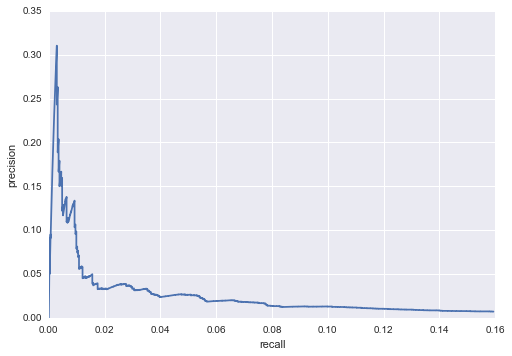

In [70]:
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')

In [71]:
combined_confidences.shape

(4218, 239)

In [53]:
pandas.value_counts(np.ndarray.flatten(gold_standard_filtered.values))

0    1004958
1       3144
dtype: int64

In [55]:
gold_standard_filtered.head()

,BSU31410,BSU29740,BSU27890,BSU40800,BSU37650,BSU05370,BSU21780,BSU05700,BSU39430,BSU02970,...,BSU02370,BSU12560,BSU24020,BSU07220,BSU15320,BSU29400,BSU27170,BSU09520,BSU25490,BSU17850
BSU00370,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BSU08100,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BSU01810,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BSU24250,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BSU36020,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [135]:
# Quick way to double check distribution of values
# pandas.value_counts(np.ndarray.flatten(combined_confidences.values))

0.000000    953195
0.048867         9
0.048881         7
0.048856         7
0.048896         7
0.048926         7
0.048898         7
0.048893         6
0.048911         6
0.048861         6
0.048923         6
0.049029         6
0.049245         6
0.049111         6
0.048869         6
0.049143         6
0.049079         6
0.048894         6
0.048861         6
0.049003         6
0.048960         6
0.048913         6
0.049121         6
0.048899         6
0.048940         6
0.049076         6
0.049033         6
0.048976         6
0.048935         6
0.048929         6
             ...  
0.098868         1
0.099018         1
0.048955         1
0.496351         1
0.147369         1
0.049012         1
0.197110         1
0.395373         1
0.295650         1
0.148451         1
0.098184         1
0.245114         1
0.343397         1
0.147629         1
0.097924         1
0.147269         1
0.099166         1
0.737655         1
0.098595         1
0.942309         1
0.695251         1
0.248608    

In [80]:
sum(betas_resc[0].sum())

3626.0785581996988

In [99]:
argsorted = np.argsort(betas_resc[1].values, axis = None)

In [103]:
argsorted[1:3000]

array([670113, 670114, 670115, ..., 669183, 669184, 669185])

## Exploratory Stuff

In [ ]:
# step one of loop
i = 0

In [ ]:
betas.append(pandas.read_csv('betas.tsv', sep='\t'))
betas_resc.append(pandas.read_csv('betas_rescaled.tsv', sep='\t'))

In [ ]:
# set a random sample of the edges to zero
# only need to do this if we have priors

# group predictors just returns the design matrix, res and prior matrix if it finds no groups:
# if no TF was excluded and no TFs were grouped, it returns the des, res, and prior.

In [ ]:
group_predictors = {}

In [ ]:
X = des_matrix.ix[:, IN['bs.pi'].ix[i,:]]
Y = res_matrix.ix[:, IN['bs.pi'].ix[i,:]]

Reminder on mutual information:
<img src="files/olah_mi.png">


In [ ]:
# Short example
x = X.ix[200,:]
y = Y.ix[200,:]

In [ ]:
H, xedges, yedges = np.histogram2d(x,y,bins)
plt.set_cmap('viridis')
im = plt.imshow(H, interpolation='none', 
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

Here is an inefficient implementation of calc_mi

In [31]:
def shannon_entropy(p):
    # Since p represents a discrete prob dist, check for floating point approximation to 1.0
    if not np.allclose(sum(p), 1.0): 
        raise Exception('Probabilities input to shannon entropy need to sum to 1')
    return - sum([x * np.log(x) for x in p if x != 0])

In [32]:
def calc_mi(x, y, bins):
    hist, scale  = np.histogram(x, bins)
    x_p = hist / float(sum(hist))
    hist, scale = np.histogram(y, bins)
    y_p = hist / float(sum(hist))
    H, xscale, yscale = np.histogram2d(x ,y, bins)
    joint_p = (H / float(sum(sum(H)))).flatten()
    return (shannon_entropy(y_p) + shannon_entropy(x_p)) - shannon_entropy(joint_p)

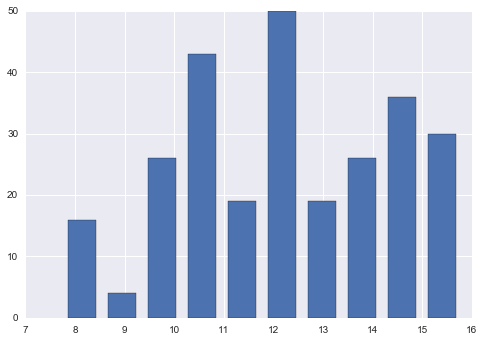

In [33]:
hist, bins = np.histogram(X.ix[10,:],bins)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

In [34]:
calc_mi(X.ix[100,:], Y.ix[100,:], PARS['mi.bins'])
# mi_matrix = [[calc_mi(X.ix[i,:], Y.ix[j,:], PARS['mi.bins']) for i in range(X.shape[0])] for j in range(Y.shape[0])] 

0.25764680571550524

In [35]:
if len(X.index) > 6000:
    # speeds up MI calculation for large datasets
    # I actually don't know what this does, since X's rows are already filtered by 'tf.with.expr', 
    # which itself if a subset of IN['tf.names']
    X = X.ix[group_predictors['tf_names'], :] # This turn X into a TFs x Samples matrix, which is what I expected it to be

In [71]:
import sklearn.metrics

In [72]:
hist, scale  = np.histogram(x, bins)
x_p = hist / float(sum(hist))
hist, scale = np.histogram(y, bins)
y_p = hist / float(sum(hist))

In [73]:
# Optionally investigate sklearn.metrics.mutual_info_score(x_p, x_p)

Call into R to calculate tlCLR

In [74]:
X.to_csv('X.csv')
Y.to_csv('Y.csv')
priors_mat.to_csv('priors_mat.csv')

In [75]:
subprocess.call(['R', '--slave', '-f', './mi_clr_driver.R'])

0

In [76]:
clr_matrix = pandas.read_csv('clr_matrix.tsv', sep='\t')

In [77]:
# Filter by tf names (this doesn't do anything in the case of B Subtilus, and should filter by group predictions)
clr_matrix = clr_matrix.ix[:, IN['tf.names']]

In [80]:
clr_matrix.to_csv('clr_matrix.csv')

In [82]:
subprocess.call(['R', '--slave', '-f', './BBSR_driver.R'])

1

In [44]:
clr_matrix.ix[:, IN['tf.names']].head()

,BSU31410,BSU29740,BSU27890,BSU40800,BSU37650,BSU05370,BSU21780,BSU05700,BSU39430,BSU02970,...,BSU02370,BSU12560,BSU24020,BSU07220,BSU15320,BSU29400,BSU27170,BSU09520,BSU25490,BSU17850
BSU00370,0.000000,1.331829,0.000000,0.053941,0.546521,0.247536,0.0,0.474254,0.102544,0.287538,...,0.632939,1.041414,0.000000,0.000000,1.074986,0.241752,0.064521,0.616567,0.130521,0.762131
BSU08100,0.000000,0.000000,0.581412,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.918470,...,0.319477,0.844766,0.302097,0.000000,1.581768,1.259320,0.222817,0.237525,0.268205,0.000000
BSU01810,1.155553,0.000000,0.000000,1.493640,0.152953,0.082841,0.0,0.218325,0.000000,0.357855,...,0.443350,1.578638,1.188237,0.000000,1.253709,0.000000,0.000000,0.043018,0.000000,0.309516
BSU24250,0.917109,2.060313,1.182781,0.000000,1.165756,0.970381,0.0,1.788951,0.424076,0.000000,...,2.110401,0.000000,0.000000,0.698148,0.000000,0.017698,1.078584,3.825155,1.904571,0.706518
BSU36020,0.770376,0.000000,1.016767,0.000000,0.000000,0.000000,0.0,0.458314,0.040748,1.104357,...,0.118278,0.000000,0.000000,0.000000,0.000000,0.811787,0.290950,0.000000,0.626139,1.087694


In [45]:
# Ignore priors for now: priors_mat

In [46]:
# Enter BBSR
from sklearn import preprocessing


In [47]:
  # Scale and permute design and response matrix
X_scaled = pandas.DataFrame(preprocessing.scale(X, axis = 1), index = X.index, columns = X.columns)
Y_scaled = pandas.DataFrame(preprocessing.scale(Y, axis = 1), index = Y.index, columns = Y.columns)

In [48]:
G = Y.shape[0]  # number of genes
genes = list(Y.index)
K = X.shape[0]  # max number of possible predictors (number of TFs)
tfs = list(X.index)
  

In [52]:
# sanity check that the scaling made each row's std deviations set to 1
np.std(X_scaled.ix[1, :])

1.0000000000000004

In [53]:
# predictors that will be used in the regression
pp = pandas.DataFrame(np.zeros((G, K)), index = genes, columns = tfs )

In [54]:
# Get top highest indices per row in clr_matrix, store as top_sorted object
top_sorted = np.argsort(clr_matrix, axis = 1).ix[:, K - PARS['max.preds']: K]

In [55]:
# for each gene, add the top nS predictors of the list to possible predictors
for i in range(G):
    pp.ix[i, top_sorted.ix[i, :]] = 1

In [56]:
# At this point, we expect the values of 1s to be equal to the number of Genes x PARS['max.preds'] (Which should be 10)
pandas.value_counts(np.ndarray.flatten(pp.values))

0.0    965922
1.0     42180
dtype: int64

In [57]:
pp.head()

,BSU31410,BSU29740,BSU27890,BSU40800,BSU37650,BSU05370,BSU21780,BSU05700,BSU39430,BSU02970,...,BSU02370,BSU12560,BSU24020,BSU07220,BSU15320,BSU29400,BSU27170,BSU09520,BSU25490,BSU17850
BSU00370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BSU08100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BSU01810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BSU24250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
BSU36020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
predictors = intersect(tfs, genes)

In [59]:
# remove self-interactions from list of potential interactions
temp_values = pp.ix[predictors,predictors].values
np.fill_diagonal(temp_values, 0)
pp.ix[predictors,predictors] = temp_values

In [62]:
idx = 0

In [63]:
def BBSR_per_gene(idx, X, Y, pp, weights, ns):
    return 0

In [64]:
ppi = pp.ix[idx, :]

In [66]:
sum(ppi)

10.0